# Benchmarking minlp and sampling based pac algorithms vs IF

In [1]:
%load_ext autoreload
%autoreload 2

### Data generation

We generate some small random datasets without any labels, but instead just to check the scaling under the various hyperparameters

In [5]:
import itertools
import numpy as np
from collections import namedtuple
np.random.seed(42)

# For starters, we'll simply benchmark on fixed randomly generated test sets of increasing size, dimension and scale (decreased density).
sizes = [100]
dimensions = [2,3]
scales = [1]

Dataset = namedtuple("Dataset", "data size dimension scale source")

datasets = {(i,j,k): Dataset(np.random.rand(i,j) * k, i, j, k, "random") for i,j,k in itertools.product(sizes, dimensions, scales)}

### Running MINLP based versions on the random datasets

Note: Below we're setting values for the min_volume and absolute errors that are based on the fact that we here know the underlying distribution to be uniform, which means that the true underlying $f(h)$ value for all patterns $h$ is actually $1$. We really only care about compuational effects, but the hope is that these are roughly the kinds of ranges that are relevant when dealing with actual anomaly detection problems and other distributions

In [6]:
# Here we define various helper functions for simpler running of experiments

from typing import Callable
import time
from rare_pattern_detect.minlp_based import MINLPModel
import mlflow

Parameter = namedtuple("Parameter", "name value")

def generate_solver_settings(in_dict):
    solver_settings = {"tee": False}
    if "absolute error" in in_dict:
        solver_settings["absolute_bound_tolerance"] = in_dict["absolute error"]
    if "relative error" in in_dict:
        solver_settings["relative_bound_tolerance"] = in_dict["relative error"]
    return solver_settings

def run_on_testset(data, testdata, **kwargs):
    solutions = []
    optimal_count = 0
    for point in testdata:
        model = MINLPModel(data, min_volume="kwargs", **kwargs)
        status, result = model.find_min_f_hat(point, solver_settings=generate_solver_settings(kwargs))
        if status == "ok":
            solutions.append(result)
            optimal_count += 1
    return solutions, optimal_count, model.solver_settings

def run_on_whole_dataset(data):
    return run_on_testset(data, data)

def run_on_fixed_size_sample(data, size, **kwargs):
    np.random.seed(0)
    N = len(data)
    assert size <= N, "size larger than dataset"
    sample_indices = np.random.choice(N, max(1, size))
    return run_on_testset(data, data[sample_indices], **kwargs)

def run_on_fraction(data, fraction, **kwargs):
    return run_on_fixed_size_sample(data, round(len(data)*fraction), **kwargs)

def benchmark_and_store_result(expression: Callable):
    start = time.time()
    res = expression.__call__()
    end = time.time()
    return *res, end - start


def run_experiment(title, datasets, execution_function, sample_size, parameters: [[Parameter]]):
    """
    Wrapper function to run an experiment

    :param title: str
    :param datasets: dict[Any, Dataset]
    :param parameters: [[Parameter]]
    :param execution_function: A callable that expects as positional arguments an numpy array of shape (n_samples, n_features), a sample size: int and returns the estimated f_hats, a count of provably optimal values, and the and the model settings as dictionary.
    """
    mlflow.set_experiment(title)
    run_number = 0
    for parameter_combo in itertools.product(*parameters):
        for dataset in datasets.values():
            run_number += 1
            print(f"Running experiment number {run_number} for dataset {(dataset.size, dataset.dimension)} with parameters {[(p.name, p.value) for p in parameter_combo]}")
            with mlflow.start_run():

                # dataset parameters
                mlflow.log_param("size", dataset.size)
                mlflow.log_param("dimension", dataset.dimension)
                mlflow.log_param("density", dataset.scale)
                mlflow.log_param("source", dataset.source)

                # option parameters
                for parameter in parameter_combo:
                    mlflow.log_param(parameter.name, parameter.value)

                parameter_dict = {parameter.name : parameter.value for parameter in parameter_combo}

                # min_volume is expressed as fraction of scale
                if "min volume" in parameter_dict:
                    parameter_dict["min volume"] *= dataset.scale

                # timing results
                f_hats, optimal_count, solver_settings, time_passed = benchmark_and_store_result(lambda: execution_function(dataset.data,sample_size, **parameter_dict))
                performance = np.mean(f_hats)
                mlflow.log_metric("time", time_passed)
                mlflow.log_metric("optimal count", optimal_count)
                mlflow.log_metric("average f_hat", performance)
                print(f"Results: average f_hat: {performance}, time: {time_passed}")

                for k,v in solver_settings.items():
                    mlflow.log_param(k,v)

In [7]:
# solver parameters
bound_included = [Parameter("bound included", v) for v in [0.05, 1]]
initial_patterns = [Parameter("initial pattern", v) for v in ["minimal", "maximal"]]
min_volumes = [Parameter("min volume", v) for v in [0.05, 0.1]]
absolute_errors = [Parameter("absolute error", v) for v in [1e-3, 0.1]] # thinking this through I believe whatever absolute error we set, we can simply add it to the epsilon of the pac performance.
relative_errors = [Parameter("relative error", v) for v in [1e-3, 0.1]] # this becomes useful especially if we set epsilon to be relative to an estimate of f.
# use_parallel_threads = [2, 4, 6]
# use_different_solvers = [Falase, ]

parameters = [bound_included,
              initial_patterns,
              min_volumes,
              absolute_errors,
              relative_errors
              ]

run_experiment(title="MINLP Tweaking Small after debugging",
               execution_function=run_on_fixed_size_sample,
               sample_size=10,
               datasets=datasets,
               parameters=parameters)

Running experiment number 1 for dataset (100, 2) with parameters [('bound included', 0.05), ('initial pattern', 'minimal'), ('min volume', 0.05), ('absolute error', 0.001), ('relative error', 0.001)]
    functionality.  (deprecated in 6.4.2) (called from
    /Users/p390943/miniforge3/envs/pac_learning/lib/python3.8/site-
    packages/pyomo/contrib/mindtpy/initialization.py:154)


KeyboardInterrupt: 


### Running sampling based IF on random datasets

Here, instead of running the exact solver, we use the sampling procedure from the isolation forest, but we use family of scoring functions that are based on the sampled distribution of f_hat.

In [2]:
from rare_pattern_detect.if_based import IFBasedRarePatternDetect

In [3]:
# the execution function for the sampling based has rare pattern algo

def run_if_pac_on_dataset(data, sample_size, **kwargs):
    if_pac_estimator = IFBasedRarePatternDetect(random_state= 42, n_estimators=kwargs["n_estimators"])
    if_pac_estimator.fit(data)
    np.random.seed(0)
    N = len(data)
    assert sample_size <= N, "size larger than dataset"
    sample_indices = np.random.choice(N, max(1, sample_size))
    f_hats = if_pac_estimator.pac_score_samples(
        data[sample_indices],
        alpha=kwargs["alpha"]
    )
    # using this method we don't generally know whether the result is optimal.
    optimal_count = 0
    return f_hats, optimal_count, {} # since the kwargs are already logged, we don't need to do it again.

In [4]:
parameters_if = [
    [Parameter("n_estimators", v) for v in [100, 1000]],
    [Parameter("alpha", v) for v in [np.inf]]
]

run_experiment('IF based PACRPAD',
               execution_function=run_if_pac_on_dataset,
               sample_size=10,
               parameters=parameters_if,
               datasets=datasets)

NameError: name 'Parameter' is not defined

### Comparing the perforamance of the two algorithms

As the IF-based algorithm is an approximate algorithm, we expect that for the same dataset, the smallest f_hat found by the MINLP algorithm is always smaller than the smallest found by the IF-based algorithm. Here we check that this is actually the case

In [11]:
minlp_runs = mlflow.search_runs("271883002980108978")
minlp_runs['model'] = "minlp"
if_pac_runs = mlflow.search_runs("755152897400520712")
if_pac_runs['model'] = 'if_pac'

In [19]:
import pandas as pd
all_runs = pd.concat([minlp_runs, if_pac_runs])
all_runs["params.n_estimators"] = all_runs["params.n_estimators"].fillna(1)

<AxesSubplot: xlabel='metrics.average f_hat', ylabel='params.dimension'>

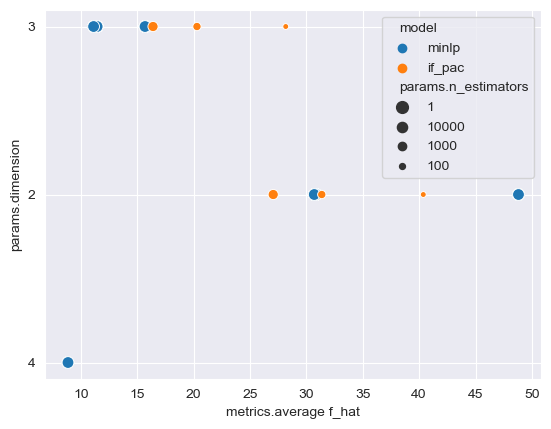

In [20]:

import seaborn as sns

df = all_runs[(all_runs['params.dimension'] <= '3') & (all_runs['status'] == 'FINISHED')].groupby(['model', 'params.dimension', 'params.n_estimators'], dropna=False)['metrics.average f_hat'].min()


sns.scatterplot(all_runs, x='metrics.average f_hat', y='params.dimension', hue="model", size="params.n_estimators")


This is weird insofar as as the if_model should never outperform the exact model.


## Comparing the performance of the IF-based PAC with the original IF

In this section, we look at the performance of the various Renyi entropies on actual anomaly datasets. We also generalise the scoring function of the IF-based PAC to include a whole range of Renyi divergences.

### Comparing time performance during fitting

In [3]:
# Loading the data
with np.load('../../ADBench/datasets/Classical/34_smtp.npz') as data:
    X = data['X']
    y = data['y']

In [ ]:
from sklearn.ensemble import IsolationForest

% timeit IsolationForest(n_estimators=1000, random_state=42).fit(X)
% timeit  IFBasedRarePatternDetect(n_estimators=1000, random_state=42).fit(X)


We see that the fitting on the IF_PAC algo takes about twice the time of the IF. This is because we traverse the same tree twice for PAC and just once for IF. (not sure why the joblib.Parallel implementation doesn't kick in, probably the trees here are too small). In a proper implementation we could calculate the areas for PAC_IF as part of the original treaversal so the fitting time should be the same.

### Comparing anomaly detection performance

In [51]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from rare_pattern_detect.if_based import renyi_divergence

def run_and_plot_ifs(dataset, params):
    fig, ax = plt.subplots(figsize=(6, 6))

    if_pac_estimator = IFBasedRarePatternDetect(random_state=42, **params)
    if_pac_estimator.fit(X)
    if_scores = if_pac_estimator.get_if_scores(X)

    RocCurveDisplay.from_predictions(y, if_scores, pos_label=0, color="red", ax=ax, name="IF")

    ps, us = if_pac_estimator._get_sample_distributions(X)

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "yellow"])
    for alpha, color in zip([0,0.5,1,2, np.inf], colors) :
        n_estimators = ps.shape[1]
        uniform = np.full_like(ps, 1.0 / n_estimators)
        if_pac_scores = np.exp(-renyi_divergence(uniform, ps / us, alpha)) / n_estimators
        RocCurveDisplay.from_predictions(y, if_pac_scores, pos_label=0, color=color, ax=ax, name=f"IF_PAC-{alpha}-{n_estimators} ")

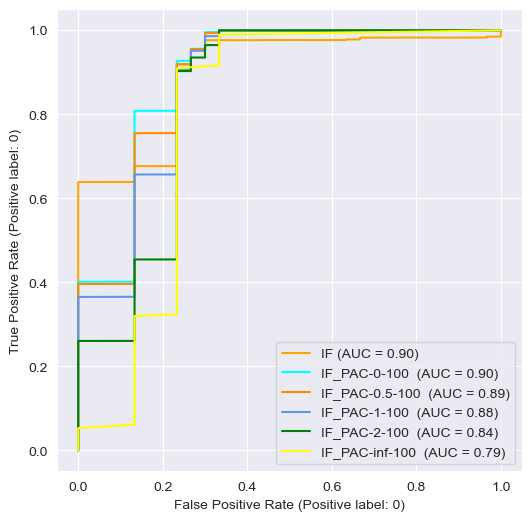

In [40]:
run_and_plot_ifs(X, {"n_estimators": 100})

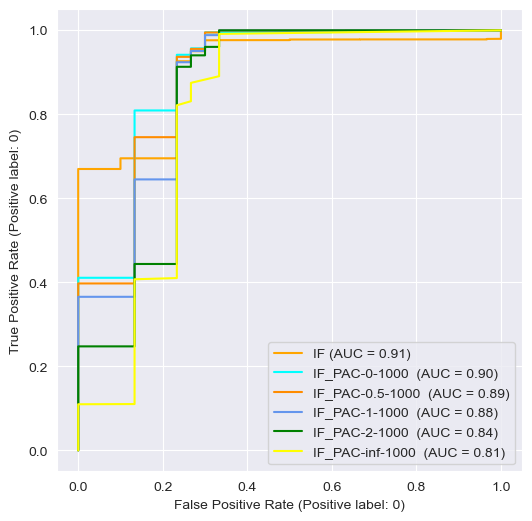

In [50]:
run_and_plot_ifs(X, {"n_estimators": 1000})

### Benchmarking on more datasets (and also including a Renyi based IF)

In [8]:
#using the examples comparison at https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_outlier_detection_bench.html#sphx-glr-auto-examples-miscellaneous-plot-outlier-detection-bench-py

# NB: we're actually modyfing this to use the full datasets

import numpy as np
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

rng = np.random.RandomState(42)


def preprocess_dataset(dataset_name):

    # loading and vectorization
    print(f"Loading {dataset_name} data")
    if dataset_name in ["http", "smtp", "SA", "SF"]:
        dataset = fetch_kddcup99(subset=dataset_name, percent10=False, random_state=rng)
        X = dataset.data
        y = dataset.target
        lb = LabelBinarizer()

        if dataset_name == "SF":
            # idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            # X = X[idx]  # reduce the sample size
            # y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            X = np.c_[X[:, :1], x1, X[:, 2:]]
        elif dataset_name == "SA":
            # idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            # X = X[idx]  # reduce the sample size
            # y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            x2 = lb.fit_transform(X[:, 2].astype(str))
            x3 = lb.fit_transform(X[:, 3].astype(str))
            X = np.c_[X[:, :1], x1, x2, x3, X[:, 4:]]
        y = (y != b"normal.").astype(int)
    if dataset_name == "forestcover":
        dataset = fetch_covtype()
        X = dataset.data
        y = dataset.target
        # idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
        # X = X[idx]  # reduce the sample size
        # y = y[idx]

        # inliers are those with attribute 2
        # outliers are those with attribute 4
        s = (y == 2) + (y == 4)
        X = X[s, :]
        y = y[s]
        y = (y != 2).astype(int)
    if dataset_name in ["glass", "wdbc", "cardiotocography"]:
        dataset = fetch_openml(
            name=dataset_name, version=1, as_frame=False, parser="pandas"
        )
        X = dataset.data
        y = dataset.target

        if dataset_name == "glass":
            s = y == "tableware"
            y = s.astype(int)
        if dataset_name == "wdbc":
            s = y == "2"
            y = s.astype(int)
            X_mal, y_mal = X[s], y[s]
            X_ben, y_ben = X[~s], y[~s]

            # downsampled to 39 points (9.8% outliers)
            # idx = rng.choice(y_mal.shape[0], 39, replace=False)
            # X_mal2 = X_mal[idx]
            # y_mal2 = y_mal[idx]
            X_mal2 = X_mal
            y_mal2 = y_mal
            X = np.concatenate((X_ben, X_mal2), axis=0)
            y = np.concatenate((y_ben, y_mal2), axis=0)
        if dataset_name == "cardiotocography":
            s = y == "3"
            y = s.astype(int)
    # 0 represents inliers, and 1 represents outliers
    y = pd.Series(y, dtype="category")
    return (X, y)

In [9]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from renyi_if.renyi_if import RenyiIsolationForest
from rare_pattern_detect.if_based import IFBasedRarePatternDetect

def compute_prediction(X, model_name):

    print(f"Computing {model_name} prediction...")
    if model_name == "LOF":
        clf = LocalOutlierFactor(n_neighbors=20, contamination="auto")
        clf.fit(X)
        y_pred = clf.negative_outlier_factor_
    if model_name == "IForest":
        clf = IsolationForest(random_state=rng, contamination="auto")
        y_pred = clf.fit(X).decision_function(X)
    if model_name == "IForest 0":
        clf = RenyiIsolationForest(random_state=rng, contamination="auto", alpha=0)
        y_pred = clf.fit(X).decision_function(X)
    if model_name == "IForest 1":
        clf = RenyiIsolationForest(random_state=rng, contamination="auto", alpha=1)
        y_pred = clf.fit(X).decision_function(X)
    if model_name == "IForest 2":
        clf = RenyiIsolationForest(random_state=rng, contamination="auto", alpha=2)
        y_pred = clf.fit(X).decision_function(X)
    if model_name == "IForest inf":
        clf = RenyiIsolationForest(random_state=rng, contamination="auto", alpha=np.inf)
        y_pred = clf.fit(X).decision_function(X)
    if model_name == "PAC IForest 0":
        clf = IFBasedRarePatternDetect(random_state=rng, contamination="auto")
        clf.fit(X)
        y_pred = clf.pac_score_samples(X, alpha=0)
    if model_name == "PAC IForest 1":
        clf = IFBasedRarePatternDetect(random_state=rng, contamination="auto")
        clf.fit(X)
        y_pred = clf.pac_score_samples(X, alpha=1)
    if model_name == "PAC IForest 2":
        clf = IFBasedRarePatternDetect(random_state=rng, contamination="auto")
        clf.fit(X)
        y_pred = clf.pac_score_samples(X, alpha=2)
    if model_name == "PAC IForest inf":
        clf = IFBasedRarePatternDetect(random_state=rng, contamination="auto")
        clf.fit(X)
        y_pred = clf.pac_score_samples(X, alpha=np.inf)

    return y_pred

Loading http data
Computing IForest prediction...
Computing IForest 0 prediction...
Computing IForest 1 prediction...
False
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
False
Computing IForest 2 prediction...
Computing IForest inf prediction...
Computing PAC IForest 0 prediction...
Computing PAC IForest 1 prediction...
Computing PAC IForest 2 prediction...
Computing PAC IForest inf prediction...
Loading smtp data
Computing IForest prediction...
Computing IForest 0 prediction...
Computing IForest 1 prediction...
Computing IForest 2 prediction...
Computing IForest inf prediction...
Computing PAC IForest 0 prediction...
Computing PAC IForest 1 prediction...
Computing PAC IForest 2 prediction...
Computing PAC IForest inf prediction...
Loading SF data
Computing IForest predic

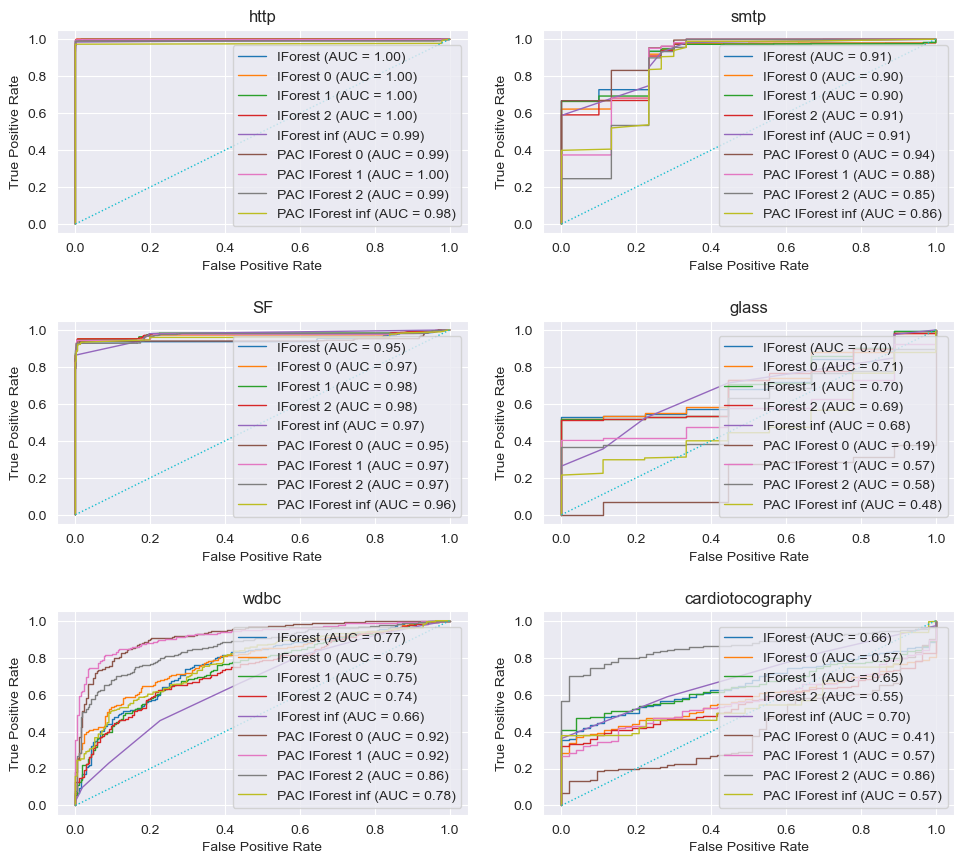

In [11]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

datasets_name = [
    "http",
    "smtp",
    # "SA",
    "SF",
    # "forestcover",
    "glass",
    "wdbc",
    "cardiotocography",
]

models_name = [
    # "LOF",
    "IForest",
    "IForest 0",
    "IForest 1",
    "IForest 2",
    "IForest inf",
    "PAC IForest 0",
    "PAC IForest 1",
    "PAC IForest 2",
    "PAC IForest inf"
]

# plotting parameters
cols = 2
linewidth = 1
pos_label = 0  # mean 0 belongs to positive class
rows = math.ceil(len(datasets_name) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

for i, dataset_name in enumerate(datasets_name):
    (X, y) = preprocess_dataset(dataset_name=dataset_name)

    for model_name in models_name:
        y_pred = compute_prediction(X, model_name=model_name)
        display = RocCurveDisplay.from_predictions(
            y,
            y_pred,
            pos_label=pos_label,
            name=model_name,
            linewidth=linewidth,
            ax=axs[i // cols, i % cols],
        )
    axs[i // cols, i % cols].plot([0, 1], [0, 1], linewidth=linewidth, linestyle=":")
    axs[i // cols, i % cols].set_title(dataset_name)
    axs[i // cols, i % cols].set_xlabel("False Positive Rate")
    axs[i // cols, i % cols].set_ylabel("True Positive Rate")
plt.tight_layout(pad=2.0)  # spacing between subplots
plt.show()

- Overall we find that there is no clear winner across the board for volume and the depth based approaches. However, we find that by introducing the alpha parameter, we can often significantly improve the performance of the classifier from the default IForest and the Default HasRarePattern algorithms
- The variance across the PAC-RPAD classifiers can be significant

## Considerations for valuable contributions of this project

A valuable paper that reports a new scoring function would report:
- on all the original datasets from the paper and others the performance of this additional scoring function. (For this it would be good if we could reproduce the original IF performance on the original datasets)
- Novelty detection vs. outlier detection (we train the model only on inliers vs outliers and inliers.
- We provide a way to tune the alpha-parameters automatically. Or at least a discussion about what kind of anomaly definition correspnds to what kind of alpha range.

In this paper we'll also have the contribution of the PAC paper. So we could prove sample efficiency wrt each of these from a PAC perspective.

## Reproducing the original reported IF performances to ensure we're using the same setup

By using the above, we already reproduce the results for http and smtp (even though weirdly this version is slightly stronger? maybe different max_heights?) Here we focus on the remainder from the original paper